## Pytorch Model Deployment

In [18]:
import torch
import torchinfo
import torchvision
from torch import nn

In [2]:
import requests
from pathlib import Path

# Download Helper functions from Laearn Pytorch repo or from anywhere on the internet
if Path("helper_functions.py").is_file():
    print("File exists skipping download.")
else:
    print("Downloading Helper Functions.py")
    requests = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(requests.content)

File exists skipping download.


In [298]:
from helper_functions import download_data, set_seeds, plot_loss_curves

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 1. Get Data
We will be working on the same data we worked earlier on Image classification problem, (DBZ character classification data)

In [5]:
import os

from pathlib import Path

# setup data path
data_path = Path("/Users/venu/Documents/Productivity/Pytorch Tutorials/data")
image_path = Path(data_path / "dragon_ball_images")

In [8]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('/Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images/train'),
 PosixPath('/Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images/test'))

### 2. DBZ Character Classifer Mini model deployment experiment outline

#### 3 Questions - 
1. What is my model ideal machine learning model deployment scenario ?
2. Where is my model going to go ?
3. How is my model going to function ?

#### Ideal use case of the model - A model that performs well and fast
1. Performs well with 95%+ accuracy.
2. Fast - real time with 30fps or 30ns latency(1/30seconds)

#### To try and achieve the above model goals we can try and experiment with 2 models - 
1. EffNetB2 Pretrained Model
2. ViT Pretrained Model

### 3. Create EffnetB2 Model Feature Extractor

Feature Extraction is a term in Transfer Learning when we want to use a pretrained model and freeze all the base layers and customize only the classifier layer.

In [10]:
import torchvision

# 1. Setup pretrained Effnetb2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT 

# 2. Get Effnetb2 Transforms
effnetb2_transforms = effnetb2_weights.transforms

# 3. Create instance of the Effnetb2 model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# 4. Freeze the base layers
for param in effnetb2.parameters():
    param.requires_grad = False

In [16]:
# # Get Summary using torch.info
# from torchinfo import summary
# summary(model = effnetb2,
#        input_size= (1, 3, 224, 224), #(batch_size, color channels, image height, image width)
#        col_names = ["input_size", "output_size", "num_params","trainable"],
#        col_width = 20,
#        row_settings = ["var_names"])

In [17]:
# Customizing the classifier head
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [19]:
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p = 0.3, inplace = True),
    nn.Linear(in_features=1408, out_features=4, bias = True)
)

In [22]:
# Get Summary using torch.info
# set_seeds()
# from torchinfo import summary
# summary(model = effnetb2,
#        input_size= (1, 3, 224, 224), #(batch_size, color channels, image height, image width)
#        col_names = ["input_size", "output_size", "num_params","trainable"],
#        col_width = 20,
#        row_settings = ["var_names"])

#### Create EffnetB2 Feature Extractor Function

In [323]:
def create_effnetb2_model(num_classes:int = 4,
                         seed:int = 99):

    # 1. create effnet pretrained weights, transforms, model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights = weights)

    # 2. Freeze the base layers and customize the classifier layer
    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p = 0.3, inplace = True),
        nn.Linear(in_features = 1408, out_features=num_classes, bias = True)
    )

    return model, transforms

In [59]:
effnetb2_model, effnetb2_transforms = create_effnetb2_model(num_classes= 4)

In [61]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

#### Create DataLoaders for EffnetB2

In [62]:
from going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloader(train_dir = train_dir,
                                                                                               test_dir = test_dir,
                                                                                               transform=effnetb2_transforms,
                                                                                               batch_size = 32,
                                                                                               num_workers=0)

In [63]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(11, 3, ['goku', 'picolo', 'trunks', 'vegeta'])

#### Trainig EffnetB2 feature extractor

In [64]:
from going_modular import engine

In [65]:
# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=effnetb2_model.parameters(),
                            lr = 0.01)

# Training Function

results_effnetb2 = engine.train(model = effnetb2_model,
                               train_dataloader=train_dataloader_effnetb2,
                               test_dataloader=test_dataloader_effnetb2,
                               loss_fn= loss_fn,
                               optimizer = optimizer,
                               epochs = 10,
                               device = "cpu")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0846 | train_acc: 0.5409 | test_loss: 0.5275 | test_acc: 0.8090
Epoch: 2 | train_loss: 0.4469 | train_acc: 0.8194 | test_loss: 0.4536 | test_acc: 0.8542
Epoch: 3 | train_loss: 0.2481 | train_acc: 0.9233 | test_loss: 0.3181 | test_acc: 0.8819
Epoch: 4 | train_loss: 0.2342 | train_acc: 0.9288 | test_loss: 0.2906 | test_acc: 0.9236
Epoch: 5 | train_loss: 0.1519 | train_acc: 0.9502 | test_loss: 0.2932 | test_acc: 0.8958
Epoch: 6 | train_loss: 0.1292 | train_acc: 0.9729 | test_loss: 0.2726 | test_acc: 0.9201
Epoch: 7 | train_loss: 0.1342 | train_acc: 0.9528 | test_loss: 0.3181 | test_acc: 0.8993
Epoch: 8 | train_loss: 0.1463 | train_acc: 0.9489 | test_loss: 0.2624 | test_acc: 0.9340
Epoch: 9 | train_loss: 0.0833 | train_acc: 0.9830 | test_loss: 0.2554 | test_acc: 0.8889
Epoch: 10 | train_loss: 0.1013 | train_acc: 0.9744 | test_loss: 0.2973 | test_acc: 0.8611


#### Inspecting the Loss curves

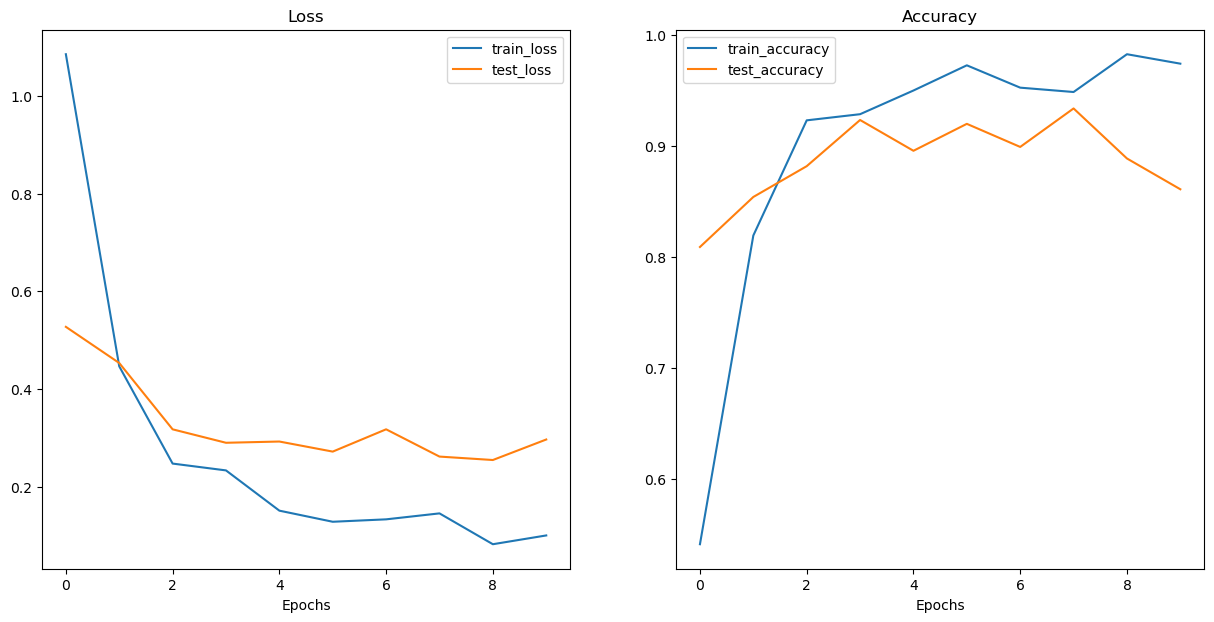

In [66]:
from helper_functions import plot_loss_curves
plot_loss_curves(results_effnetb2)

#### Saving Effnetb2 Feature Extractor Model

In [67]:
from going_modular import utils

In [288]:
utils.save_model(model = effnetb2_model,
                target_dir = "/Users/venu/Documents/Productivity/Pytorch Tutorials/Models",
                model_name = "Effnetb2_Pretrained_Feature_Extractor_DBZ_char_classifier.pth")

[INFO] Saving model to: /Users/venu/Documents/Productivity/Pytorch Tutorials/Models/Effnetb2_Pretrained_Feature_Extractor_DBZ_char_classifier.pth


### Inspecting the size of our EffnetB2 Feature Extractor Model

In [289]:
from pathlib import Path

# get the model size in bytes and then convert it into megabites
pretrained_effnetb2_model_size = Path("models/Effnetb2_Pretrained_Feature_Extractor_DBZ_char_classifier.pth").stat().st_size/ (1024 * 1024)
print(f"The model size is {pretrained_effnetb2_model_size:.2f} MB")

The model size is 29.85 MB


#### Create Dictionary with Effnetb2 statistics

In [75]:
# counting number of paramters
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2_model.parameters())
effnetb2_total_params

7706630

In [78]:
effnetb2_stats = {"test_loss": results_effnetb2["test_loss"][-1],
                 "test_acc": results_effnetb2["test_acc"][-1],
                 "number of params": effnetb2_total_params,
                 "Model Size[MB]": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.29731755952040356,
 'test_acc': 0.8611111111111112,
 'number of params': 7706630,
 'Model Size[MB]': 29.8522891998291}

## 4. Create ViT Base Feature Extractor Model

In [84]:
# function to create feature extractor model for vit base which returns model and transform

def create_vitbase_model(num_classes:int = 4,
                        seed = 95):
    """Returns ViT Base feature extractor model with base layers frozen and customized classifier layer"""
    # Define weights, transforms and instance of feature extractor model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transform = weights.transforms()
    model = torchvision.models.vit_b_16(weights = weights)

    # Freeze the base layers
    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)

    # Customize the classifier layer
    model.heads = nn.Sequential(
        nn.Linear(in_features= 768,
                 out_features= num_classes)
    )

    return model, transform

    

In [85]:
vitbase_model, vitbase_transforms = create_vitbase_model(num_classes= 4)

In [86]:
vitbase_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [88]:
# create dataloaders and class_names
train_dataloader_vitbase, test_dataloader_vitbase, class_names = data_setup.create_dataloader(train_dir= train_dir,
                                                                                             test_dir = test_dir,
                                                                                             transform=vitbase_transforms,
                                                                                             batch_size = 32,
                                                                                             num_workers= 0)

In [89]:
len(train_dataloader_vitbase), len(test_dataloader_vitbase), class_names

(11, 3, ['goku', 'picolo', 'trunks', 'vegeta'])

#### Training ViT Base Feature Extractor Model

In [90]:
# Define Optimizer and Loss Function

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params= vitbase_model.parameters(),
                            lr = 0.01)

vitbase_model_results = engine.train(model = vitbase_model,
                                    train_dataloader= train_dataloader_vitbase,
                                    test_dataloader= test_dataloader_vitbase,
                                    loss_fn= loss_fn,
                                    optimizer = optimizer,
                                    epochs = 10,
                                    device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9715 | train_acc: 0.5636 | test_loss: 0.5767 | test_acc: 0.7326
Epoch: 2 | train_loss: 0.2805 | train_acc: 0.9004 | test_loss: 0.3580 | test_acc: 0.8924
Epoch: 3 | train_loss: 0.1337 | train_acc: 0.9602 | test_loss: 0.3128 | test_acc: 0.8785
Epoch: 4 | train_loss: 0.0811 | train_acc: 0.9830 | test_loss: 0.3338 | test_acc: 0.8403
Epoch: 5 | train_loss: 0.0583 | train_acc: 0.9943 | test_loss: 0.3057 | test_acc: 0.8924
Epoch: 6 | train_loss: 0.0401 | train_acc: 0.9972 | test_loss: 0.3099 | test_acc: 0.8542
Epoch: 7 | train_loss: 0.0299 | train_acc: 1.0000 | test_loss: 0.2979 | test_acc: 0.8681
Epoch: 8 | train_loss: 0.0253 | train_acc: 0.9972 | test_loss: 0.2945 | test_acc: 0.8785
Epoch: 9 | train_loss: 0.0202 | train_acc: 1.0000 | test_loss: 0.2926 | test_acc: 0.8681
Epoch: 10 | train_loss: 0.0178 | train_acc: 1.0000 | test_loss: 0.2922 | test_acc: 0.8785


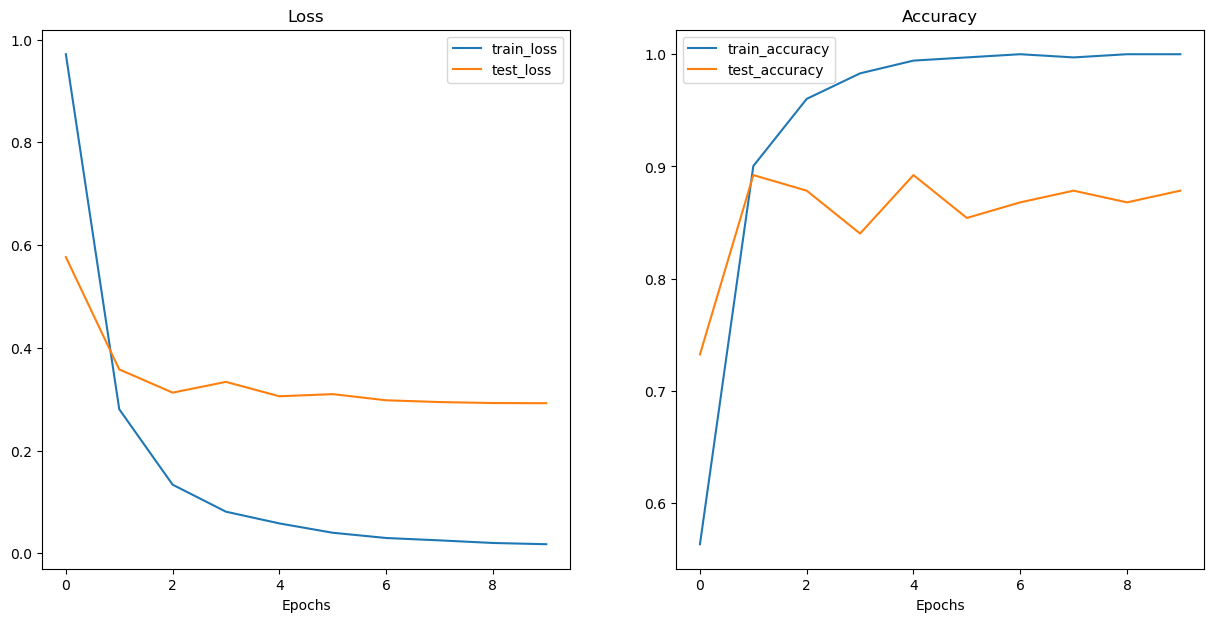

In [91]:
from helper_functions import plot_loss_curves
plot_loss_curves(vitbase_model_results)

In [92]:
utils.save_model(model = effnetb2_model,
                target_dir = "/Users/venu/Documents/Productivity/Pytorch Tutorials/Models",
                model_name = "ViTBase_Pretrained_Feature_Extractor_DBZ_char_classifier.pth")

[INFO] Saving model to: /Users/venu/Documents/Productivity/Pytorch Tutorials/Models/ViTBase_Pretrained_Feature_Extractor_DBZ_char_classifier.pth


#### Inspecting the size of the ViTBase Feature Extractor Model

In [93]:
from pathlib import Path

# get the model size in bytes and then convert it into megabites
pretrained_vitbase_model_size = Path("models/ViTBase_Pretrained_Feature_Extractor_DBZ_char_classifier.pth").stat().st_size/ (1024 * 1024)
print(f"The model size is {pretrained_vitbase_model_size:.2f} MB")

The model size is 29.85 MB


In [99]:
# counting number of paramters
vitbasemodel_total_params = sum(torch.numel(param) for param in vitbase_model.parameters())
print(f"Total Number of Parameters: {vitbasemodel_total_params}")

Total Number of Parameters: 85801732


In [100]:
vitbase_model_stats = {"test_loss": vitbase_model_results["test_loss"][-1],
                 "test_acc": vitbase_model_results["test_acc"][-1],
                 "number of params": vitbasemodel_total_params,
                 "Model Size[MB]": pretrained_vitbase_model_size}
vitbase_model_stats

{'test_loss': 0.2922341028849284,
 'test_acc': 0.8784722222222222,
 'number of params': 85801732,
 'Model Size[MB]': 29.8518009185791}

## 5. Making Predictions with trained model

### Our Goal - 
1. Performs well
2. Predicts Fast

##### To Test `Predicts Fast` - 
1. Loop through random set of Test images
2. Time how long each model takes to make predictions on few set of sample images

In [113]:
from pathlib import Path

# get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpeg"))
sample = test_data_paths[-1]
sample.parent.stem

'trunks'

### Create a function to perform the above required operation

1. Create a function which takes -
   1. a list of image paths
   2. trained PyTorch Model
   3. a series of transforms
   4. list of target class names
   5. target device
2. Create an empty list which contains a list of all predictions which we will return
3. loop through the target paths (the below steps will happen inside the loop)
4. Create an empty dictionary for each sample where we append the prediction stats
5. From the filepath extract the ground truth class name
6. start prediction timer()
7. Open the image using `PIL.Image.open(path)`
8. Transform the image using model corresponding transforms and add batch dimension and send to target device
9. Prepare the model for inference by using `.eval()` and send the model to target device
10. Turn on `torch.inference_mode()` and pass the transformed test image and perform forward pass, calculate pred_prob and also pred_class
11. Add the pred_prob and the pred_class to the empty dictionary
12. End the timer() and add the prediction time to the dictionary
13. Check if the predicted class matches with the ground truth class name
14. Append the updated dictionary to the empty list of predictions
15. Return the list of prediction dictionaries

In [150]:
import pathlib
import torch
from PIL import Image

from timeit import default_timer as timer
from IPython.display import ProgressBar
from typing import List, Dict

# 1. Create a function which takes - a list of image paths, trained PyTorch Model, a series of transforms, 
# list of target class names, target device
def predict_and_score(model:torch.nn.Module,
                     image_paths: List[str],
                     transform = torchvision.transforms,
                     class_names = List[str],
                     device= device):

    # 2. Create an empty list which contains a list of all predictions which we will return
    prediction_list = []

    # 3. loop through the target image paths -
    for path in (image_paths):

        #4. Create an empty dictionary for each sample. (Prediction stats will be saved here)
        prediction_dict = {}

        # 5. get the ground truth form the image path
        prediction_dict["image_path"] = path
        class_name = path.parent.stem
        prediction_dict["class_name"] = class_name

        # 6. start the prediction timer
        start_time = timer()

        # 7. Open the image using 
        img = Image.open(path)

        #8. Tranform the opened image using required model transforms, also we need to add the batch dimension at 0th dim and
        # send to target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        #9. Put the model in eval mode and Prepare the model for inference mode and send the model to target device
        model.to(device)
        model.eval()

        # 10. Turn on torch.inference_mode()  
        # and pass the transformed test image and perform forward pass, calculate pred_prob and also pred_class
        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit, dim = 1)
            pred_label = torch.argmax(pred_prob, dim = 1)
            pred_class = class_names[pred_label.cpu()] # python variables live on the cpu

        # 11. Add the prediction prob and prediction class to prediction_dict dictionary
            #print(pred_prob)
            #print(pred_prob.unsqueeze(0))
            #print(pred_prob.unsqueeze(0).max())
            prediction_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            prediction_dict["pred_class"] = pred_class

            #12. End the prediction Timer, calculate the time and add the time stat
            end_time = timer()
            prediction_dict["time_for_pred"] = round(end_time - start_time, 4)
        
        # 13. Check if the predicted class matches the ground truth class
        prediction_dict["Correct Prediction"] = pred_class == class_name

        # 14. Append the updated dictionary to the empty list of predictions
        prediction_list.append(prediction_dict)
        

    #15. Return prediction list
    return prediction_list

#### Making and timing predictions using EffnetB2

In [151]:
effnetb2_test_prediction_list = predict_and_score(model=effnetb2_model,
                 image_paths= test_data_paths,
                 transform= effnetb2_transforms,
                 class_names=class_names,
                 device = "cpu")

In [152]:
vitbase_test_prediction_list = predict_and_score(model=vitbase_model,
                 image_paths= test_data_paths,
                 transform= vitbase_transforms,
                 class_names=class_names,
                 device = "cpu")

In [154]:
effnetb2_test_prediction_list[:2]

[{'image_path': PosixPath('/Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images/test/picolo/download (5).jpeg'),
  'class_name': 'picolo',
  'pred_prob': 0.9999,
  'pred_class': 'picolo',
  'time_for_pred': 0.13,
  'Correct Prediction': True},
 {'image_path': PosixPath('/Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images/test/picolo/download.jpeg'),
  'class_name': 'picolo',
  'pred_prob': 0.9588,
  'pred_class': 'picolo',
  'time_for_pred': 0.0811,
  'Correct Prediction': True}]

In [168]:
# Turn the prediction stat dictionaries into df
import pandas as pd
effnetb2_test_prediction_df = pd.DataFrame(effnetb2_test_prediction_list)
vitbase_test_prediction_df = pd.DataFrame(vitbase_test_prediction_list)

effnetb2_test_prediction_df.head(-5)

,image_path,class_name,pred_prob,pred_class,time_for_pred,Correct Prediction
0,/Users/venu/Documents/Productivity/Pytorch Tut...,picolo,0.9999,picolo,0.1300,True
1,/Users/venu/Documents/Productivity/Pytorch Tut...,picolo,0.9588,picolo,0.0811,True
2,/Users/venu/Documents/Productivity/Pytorch Tut...,picolo,1.0000,picolo,0.0761,True
3,/Users/venu/Documents/Productivity/Pytorch Tut...,picolo,0.9997,picolo,0.0728,True
4,/Users/venu/Documents/Productivity/Pytorch Tut...,picolo,0.9994,picolo,0.0738,True
...,...,...,...,...,...,...
69,/Users/venu/Documents/Productivity/Pytorch Tut...,trunks,0.8142,trunks,0.0738,True
70,/Users/venu/Documents/Productivity/Pytorch Tut...,trunks,0.9504,trunks,0.0725,True
71,/Users/venu/Documents/Productivity/Pytorch Tut...,trunks,0.9993,trunks,0.0730,True
72,/Users/venu/Documents/Productivity/Pytorch Tut...,trunks,0.8092,trunks,0.0716,True


In [159]:
vitbase_test_prediction_df.head(-5)

,image_path,class_name,pred_prob,pred_class,time_for_pred,Correct Prediction
0,/Users/venu/Documents/Productivity/Pytorch Tut...,picolo,0.9969,picolo,0.1999,True
1,/Users/venu/Documents/Productivity/Pytorch Tut...,picolo,0.4999,picolo,0.1460,True
2,/Users/venu/Documents/Productivity/Pytorch Tut...,picolo,1.0000,picolo,0.1416,True
3,/Users/venu/Documents/Productivity/Pytorch Tut...,picolo,0.9998,picolo,0.1386,True
4,/Users/venu/Documents/Productivity/Pytorch Tut...,picolo,0.9999,picolo,0.1397,True
...,...,...,...,...,...,...
69,/Users/venu/Documents/Productivity/Pytorch Tut...,trunks,0.8373,trunks,0.2001,True
70,/Users/venu/Documents/Productivity/Pytorch Tut...,trunks,0.5706,goku,0.2165,False
71,/Users/venu/Documents/Productivity/Pytorch Tut...,trunks,0.9998,trunks,0.2414,True
72,/Users/venu/Documents/Productivity/Pytorch Tut...,trunks,0.9855,trunks,0.2215,True


In [170]:
vitbase_test_prediction_df["Correct Prediction"].value_counts()

Correct Prediction
True     70
False     9
Name: count, dtype: int64

In [171]:
 effnetb2_test_prediction_df["Correct Prediction"].value_counts()

Correct Prediction
True     69
False    10
Name: count, dtype: int64

### Find the average time for prediction

In [172]:
effnetb2_average_prdeiction = round(effnetb2_test_prediction_df["time_for_pred"].mean(), 3)
effnetb2_average_prdeiction

0.075

In [173]:
vitbase_average_prdeiction = round(vitbase_test_prediction_df["time_for_pred"].mean(), 3)
vitbase_average_prdeiction

0.185

In [175]:
vitbase_model_stats["average_prediction_time"] = vitbase_average_prdeiction
effnetb2_stats["average_prediction_time"] = effnetb2_average_prdeiction

In [176]:
vitbase_model_stats

{'test_loss': 0.2922341028849284,
 'test_acc': 0.8784722222222222,
 'number of params': 85801732,
 'Model Size[MB]': 29.8518009185791,
 'average_prediction_time': 0.185}

In [177]:
effnetb2_stats

{'test_loss': 0.29731755952040356,
 'test_acc': 0.8611111111111112,
 'number of params': 7706630,
 'Model Size[MB]': 29.8522891998291,
 'average_prediction_time': 0.075}

#### Model Performance Comparision Statistics

In [178]:
comparision_df = pd.DataFrame([vitbase_model_stats, effnetb2_stats])

In [180]:
comparision_df["Model"] = ["Vit Base Model", "EffnetB2 Model"]

In [182]:
comparision_df["test_acc"] = round(comparision_df["test_acc"]*100, 2)

In [183]:
comparision_df

,test_loss,test_acc,number of params,Model Size[MB],average_prediction_time,Model
0,0.292234,87.85,85801732,29.851801,0.185,Vit Base Model
1,0.297318,86.11,7706630,29.852289,0.075,EffnetB2 Model


### Inference drawn from comparision metrics

1. We could see that both the models acc is almost close.
2. However we could see that when considering the number of params, the number of params for ViT Base model is far higher when compared to EffnetB2 Model although they both have similar accuracy scores
3. We could see that on the average prediction time EffnetB2 model takes very less for single prediction, also the model size is similar when compared against each other.

#### Compare Ratios of EffnetB2 Model to ViT Base model

In [185]:
ratio_compare_df = pd.DataFrame(data = (comparision_df.set_index("Model").loc["EffnetB2 Model"] / comparision_df.set_index("Model").loc["Vit Base Model"]),
                               columns= ["EffnetB2 to ViT Ratios"])

In [186]:
ratio_compare_df

,EffnetB2 to ViT Ratios
test_loss,1.017395
test_acc,0.980194
number of params,0.089819
Model Size[MB],1.000016
average_prediction_time,0.405405


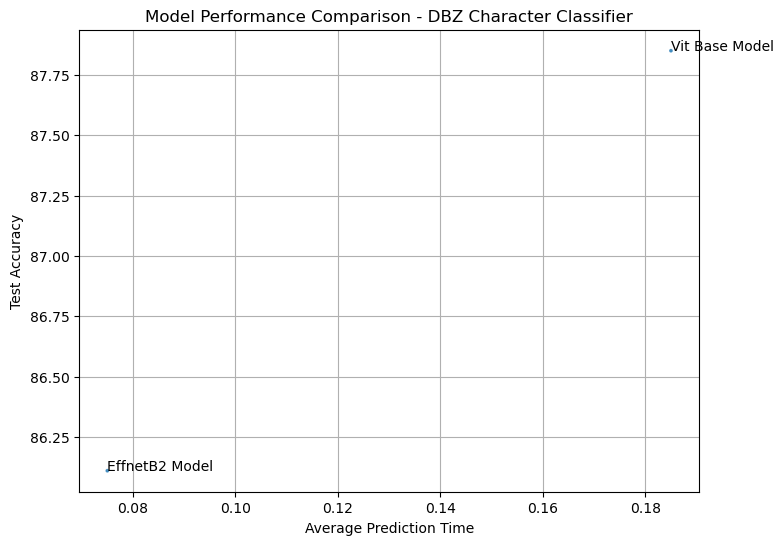

In [192]:
import matplotlib.pyplot as plt

# Create a scatter plot with size based on Model Size[MB]
plt.figure(figsize=(8, 6))
plt.scatter(comparision_df["average_prediction_time"], comparision_df["test_acc"], s=comparision_df["Model Size[MB]"] / 10, alpha=0.7)

# Add labels and title
plt.xlabel("Average Prediction Time")
plt.ylabel("Test Accuracy")
plt.title("Model Performance Comparison - DBZ Character Classifier")

# Add legend
for i, row in comparision_df.iterrows():
    plt.annotate(row["Model"], (row["average_prediction_time"], row["test_acc"]), fontsize=10)

plt.grid(True)
plt.show()

# Using Gradio to Deploy the model - **EffnetB2 Model**

Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere!

In [193]:
pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 3.8 MB/s eta 0:00:00
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 18.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 9.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 15.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 21.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 1.9 MB/s eta 0:00:00
Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12

In [197]:
import gradio as gr
print(f"Current Gradio version is {gr.__version__}")

Current Gradio version is 4.44.0


## Gradio Overview
1. Gradio helps you create demos for our Machine Learning Model.
2. Why create a Demo? So that we can test our model in the real world and also other people can test our model.
3. Deployment is as important as training the model.
4. What we want to achieve is -
   `input(image) -->  function(model) -->  output(label)`

### Creating a function to map our inputs and outputs

In [201]:
# put the model on cpu
effnetb2_model = effnetb2_model.to("cpu")

next(iter(effnetb2_model.parameters())).device

device(type='cpu')

import gradio as gr

def greet(name, intensity):
    return "Hello, " + name + "!" * int(intensity)

demo = gr.Interface(
    fn=greet,
    inputs=["text", "slider"],
    outputs=["text"],
)

demo.launch()

#### gradio takes a function of the model which we want to feed to the interface class

#### we will create a function `predict()` which will do the following - 

#### input (image) --> model function(EffnetB2) --> Output Dict{prediction label, prediction time}

In [221]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:

    #0. Start timer()
    start_time = timer()

    #1. takes an image as input
    # input_image = img
    
    #2. Does the required transformation on the image
    transformed_image = effnetb2_transforms(img).unsqueeze(0) # Add batch dimension at 0th index

    #3. Put the model in eval mode and passes the image to the model
    effnetb2_model.eval()
    with torch.inference_mode():
        prediction_probs = torch.softmax(effnetb2_model(transformed_image), dim = 1)
        print(prediction_probs)
    #4. Craete a dictionary which store the prediction probabilities
    pred_labels_probs =  {class_names[i]:float(prediction_probs[0][i]) for i in range(len(class_names))}
    #6. End timer()
    end_timer = timer()
    total_prediction_time = round(end_timer - start_time, 3)

    #7. Return the prediction dictionary class names and prediction time
    return pred_labels_probs, total_prediction_time

#### Pass random images through the above function to see the functionality - 

In [270]:
from PIL import Image
import random

test_image_paths = list(Path(test_dir).glob("*/*.jpeg"))
test_image_paths[4]


PosixPath('/Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images/test/picolo/download (3).jpeg')

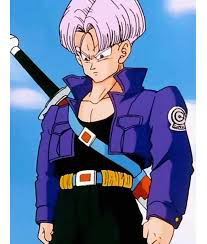

In [239]:
random_image_sample = random.sample(test_image_paths, k = 1)[0]
img =Image.open(random_image_sample)
img

In [240]:
predict_label_probs, preiction_time = predict(img)
predict_label_probs, preiction_time

tensor([[2.7090e-04, 8.6495e-05, 9.9963e-01, 1.2731e-05]])


({'goku': 0.0002709031687118113,
  'picolo': 8.649489609524608e-05,
  'trunks': 0.9996298551559448,
  'vegeta': 1.273054294870235e-05},
 0.111)

### Creating of sample images as examples

In [257]:
example_image_paths = [[str(file_path) for file_path in random.sample(test_image_paths, k = 5)]]
# sample images are taken as list of lits

In [258]:
example_image_paths

[['/Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images/test/trunks/download (9).jpeg',
  '/Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images/test/vegeta/download (16).jpeg',
  '/Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images/test/goku/download (4).jpeg',
  '/Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images/test/picolo/download (3).jpeg',
  '/Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images/test/goku/download (10).jpeg']]

### Building a Gradio Interface

We see that the Interface class is initialized with three required parameters:

1. fn: the function to wrap a user interface (UI) around inputs: which Gradio component(s) to use for the input. 
2. The number of components should match the number of arguments in your function. outputs: which Gradio component(s) to use for the output.
3. The number of components should match the number of return values from your function.

In [350]:
import gradio as gr

In [264]:
title = "Dragon Ball Z Character Classifier (Goku, Vegeta, Trunks, Picolo) 🔥🔥🔥"
description = "An [EffnetB2 Feature Extractor model] (https://pytorch.org/vision/0.18/models/generated/torchvision.models.efficientnet_b2.html) used to classify DBZ characters - Goku, Vegeta, Trunks, Picolo"

demo = gr.Interface(fn = predict,
                   inputs = gr.Image(type = "pil"),
                   outputs = [gr.Label(num_top_classes = 4, label = "Predictions"),
                            gr.Number(label = "Prediction Time (s)")],
                   examples = example_image_paths,
                   title = title,
                   description = description)

In [265]:
# Launch the demo
demo.launch(debug = False,
          share = True)

Running on local URL:  http://127.0.0.1:7863
Running on public URL: https://89bb1f81814f3368bc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


tensor([[6.9420e-02, 3.6704e-04, 7.6671e-02, 8.5354e-01]])
tensor([[8.8844e-05, 1.7277e-04, 8.5849e-04, 9.9888e-01]])
tensor([[0.3168, 0.0122, 0.1525, 0.5185]])
tensor([[0.0439, 0.9458, 0.0015, 0.0088]])
tensor([[8.2900e-01, 4.6246e-03, 7.2039e-04, 1.6566e-01]])
tensor([[5.0664e-03, 8.5917e-04, 2.0325e-03, 9.9204e-01]])
tensor([[1.5606e-02, 3.5512e-06, 1.4778e-03, 9.8291e-01]])


## 8. Turn our DBZ Character Classifier into a Deployable app using HuggingFace Spaces
1. We are going to use HuggingFace Spaces. Hugging Face Spaces make it easy for you to create and deploy ML-powered demos in minutes.
2. Hugging Face Spaces is a platform that allows you to host and share your machine learning models, datasets, and demos with the community. It's a part of the Hugging Face ecosystem, which is known for its popular Transformers library and model hub.
3. Git Large Files - Git Large File Storage (LFS) replaces large files such as audio samples, videos, datasets, and graphics with text pointers inside Git, while storing the file contents on a remote server like GitHub.com or GitHub Enterprise.

#### Required Gradio App Structure

`Jupyter_Notebook --> Folder with all gadio Files  -->  Upload app files to HuggingFace Spaces  -->  Deploy`

### Create a demos folder to store our DBZ app files

The shutil module offers a number of high-level operations on files and collections of files. In particular, functions are provided which support file copying and removal. For operations on individual files, see also the os module.

In [262]:
import shutil
from pathlib import Path

# Create a Demo Path for BBZ Classifer
dbz_char_classiifer_path = Path("demos/dbz_char_classifier/")

# Remove files if they already might exist and create a new file directory
if dbz_char_classiifer_path.exists():
    shutil.rmtree(dbz_char_classiifer_path)
    dbz_char_classiifer_path.mkdir(parents = True,
                                  exist_ok= True)
else:
    dbz_char_classiifer_path.mkdir(parents = True,
                                  exist_ok= True)

In [266]:
!ls demos/dbz_char_classifier/

### Create a Folder of example images to use with demo app
1. We want 4 sample images
2. Images should be from test set, Images should be list of lists format

In [275]:
# Create an example directory
dbz_classifier_examples_path = dbz_char_classiifer_path / "examples"
dbz_classifier_examples_path.mkdir(parents = True, exist_ok = True)

# Collect 4 Random Image paths from the test_dir 
dbz_classifier_examples = [ Path('/Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images/test/goku/download (1).jpeg'),
                           Path('/Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images/test/vegeta/download (16).jpeg'),
                            Path('/Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images/test/trunks/download (4).jpeg'),
                            Path('/Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images/test/picolo/download (13).jpeg'),
                          ]

# copy the tree images to examples directory
for example in dbz_classifier_examples:
    destination = dbz_classifier_examples_path / example.name
    print(f"[INFO] copying {example} to {destination}")
    shutil.copy2(src = example,
                dst = destination)

[INFO] copying /Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images/test/goku/download (1).jpeg to demos/dbz_char_classifier/examples/download (1).jpeg
[INFO] copying /Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images/test/vegeta/download (16).jpeg to demos/dbz_char_classifier/examples/download (16).jpeg
[INFO] copying /Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images/test/trunks/download (4).jpeg to demos/dbz_char_classifier/examples/download (4).jpeg
[INFO] copying /Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images/test/picolo/download (13).jpeg to demos/dbz_char_classifier/examples/download (13).jpeg


#### Get the examples into examples_list -> list of lists

In [276]:
example_list = [["examples/" + example] for example in os.listdir(dbz_classifier_examples_path)]
example_list

[['examples/download (1).jpeg'],
 ['examples/download (4).jpeg'],
 ['examples/download (13).jpeg'],
 ['examples/download (16).jpeg']]

#### Moving out trained EffnetB2 model to DBZ charcter classifer demo directory

In [293]:
import shutil

# Create a source path for our target model
effnetb2_dbz_classifier_model_path = "Models/Effnetb2_Pretrained_Feature_Extractor_DBZ_char_classifier.pth"

# Create a destination folder where we want to move the model to
effnetb2_dbz_classifier_model_destination = dbz_char_classiifer_path / effnetb2_dbz_classifier_model_path.split("/")[1]

# try to move the model file

try:
    print(f"[INFO] Attempting to move {effnetb2_dbz_classifier_model} to {effnetb2_dbz_classifier_model_destination}")

    # Move the model
    shutil.move(src = effnetb2_dbz_classifier_model,
               dst = effnetb2_dbz_classifier_model_destination)

    print(f"[INFO] Model move complete..")
    # If the model has already been moved, check if it exists in the destination folder
except:
    print(f"[INFO] No model found at {effnetb2_dbz_classifier_model}, perhaps its already been moved.")
    print(f"[INFO] Model exists at {effnetb2_dbz_classifier_model_destination}: {effnetb2_dbz_classifier_model_destination.exists()}")

[INFO] Attempting to move Models/Effnetb2_Pretrained_Feature_Extractor_DBZ_char_classifier.pth to demos/dbz_char_classifier/Effnetb2_Pretrained_Feature_Extractor_DBZ_char_classifier.pth
[INFO] No model found at Models/Effnetb2_Pretrained_Feature_Extractor_DBZ_char_classifier.pth, perhaps its already been moved.
[INFO] Model exists at demos/dbz_char_classifier/Effnetb2_Pretrained_Feature_Extractor_DBZ_char_classifier.pth: True


### Turning EffnetB2 Model into a Python Script (model.py)

In [338]:
%%writefile demos/dbz_char_classifier/model.py

import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes:int = 4,
                         seed:int = 99):

    # 1. create effnet pretrained weights, transforms, model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights = weights)

    # 2. Freeze the base layers and customize the classifier layer
    for param in model.parameters():
        param.requires_grad = False

    #3. Change classifier head with random seed for reproductivity
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p = 0.3, inplace = True),
        nn.Linear(in_features = 1408, out_features=num_classes, bias = True)
    )

    return model, transforms

Writing demos/dbz_char_classifier/model.py


In [339]:
from demos.dbz_char_classifier import model

In [341]:
import importlib
importlib.reload(model)

<module 'demos.dbz_char_classifier.model' from '/Users/venu/Documents/Productivity/Pytorch Tutorials/demos/dbz_char_classifier/model.py'>

### Turning DBZ Character classiifer Gradio app into Python Script(app.py)

This will have 4 major points:
1. Imports and class names setuo
2. Model and transforms preperation
3. Predict Function
4. Grado Interface + Launch Command

In [345]:
%%writefile demos/dbz_char_classifier/app.py

## Imports and class names
import gardio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# setup class names
class_names = ['goku', 'picolo', 'trunks', 'vegeta']

# Model and transforms
effnetb2_model, effnetb2_transforms = create_effnetb2_model(num_classes= = len(class_names))

# Load save weights
effnetb2_model.load_state_dict(
    f = "/Users/venu/Documents/Productivity/Pytorch Tutorials/demos/dbz_char_classifier/Effnetb2_Pretrained_Feature_Extractor_DBZ_char_classifier.pth",
    map_location = torch.device("cpu")
)

# Predict Function
def predict(img) -> Tuple[Dict, float]:

    #0. Start timer()
    start_time = timer()

    #1. takes an image as input
    # input_image = img
    
    #2. Does the required transformation on the image
    transformed_image = effnetb2_transforms(img).unsqueeze(0) # Add batch dimension at 0th index

    #3. Put the model in eval mode and passes the image to the model
    effnetb2_model.eval()
    with torch.inference_mode():
        prediction_probs = torch.softmax(effnetb2_model(transformed_image), dim = 1)
        print(prediction_probs)
    #4. Craete a dictionary which store the prediction probabilities
    pred_labels_probs =  {class_names[i]:float(prediction_probs[0][i]) for i in range(len(class_names))}
    #6. End timer()
    end_timer = timer()
    total_prediction_time = round(end_timer - start_time, 3)

    #7. Return the prediction dictionary class names and prediction time
    return pred_labels_probs, total_prediction_time

# Create path for examples
example_image_paths = [["examples"/+ example] for example in os.listdir("exmaples")]


# Gradio app
title = "Dragon Ball Z Character Classifier (Goku, Vegeta, Trunks, Picolo) 🔥🔥🔥"
description = "An [EffnetB2 Feature Extractor model] (https://pytorch.org/vision/0.18/models/generated/torchvision.models.efficientnet_b2.html) used to classify DBZ characters - Goku, Vegeta, Trunks, Picolo"

demo = gr.Interface(fn = predict,
                   inputs = gr.Image(type = "pil"),
                   outputs = [gr.Label(num_top_classes = 4, label = "Predictions"),
                            gr.Number(label = "Prediction Time (s)")],
                   examples = example_image_paths,
                   title = title,
                   description = description)

# Launch the demo
demo.launch(debug = False,
          share = True)

Writing demos/dbz_char_classifier/app.py


In [347]:
torch.__version__

'2.2.2'

In [348]:
torchvision.__version__

'0.17.2'

In [351]:
gr.__version__

'4.44.0'

In [352]:
%%writefile demos/dbz_char_classifier/requirements.txt
torch == 2.2.2
torchvision == 0.17.2
gr == 4.44.0

Writing demos/dbz_char_classifier/requirements.txt


### 9.Deploying DBZ_Char_Classifier app into HuggingFace Spaces

In [354]:
!cd demos/dbz_char_classifier && zip -r ../dbz_char_classifier.zip * -x "*.pyc*""*.ipynb*""*__pycace__*""*ipynb_checkpoints*"

  adding: Effnetb2_Pretrained_Feature_Extractor_DBZ_char_classifier.pth (deflated 8%)
  adding: __pycache__/ (stored 0%)
  adding: __pycache__/model.cpython-311.pyc (deflated 37%)
  adding: app.py (deflated 55%)
  adding: examples/ (stored 0%)
  adding: examples/download (1).jpeg (deflated 0%)
  adding: examples/download (4).jpeg (deflated 0%)
  adding: examples/download (13).jpeg (deflated 0%)
  adding: examples/download (16).jpeg (deflated 0%)
  adding: model.py (deflated 49%)
  adding: requirements.txt (deflated 16%)
